Dataset Link: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [ ]:
from google.colab import userdata
import os

In [ ]:
import kagglehub

path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset downloaded successfully to: {path}")

Dataset downloaded successfully to: /kaggle/input/satellite-image-classification


In [ ]:
data_dir = os.path.join(path, 'data')
print("\nContents of the data directory:")
print(os.listdir(data_dir))


Contents of the data directory:
['cloudy', 'desert', 'green_area', 'water']


In [ ]:
import os
total_size_bytes = 0
for dirpath, dirnames, filenames in os.walk(path):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size_bytes += os.path.getsize(fp)

total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total dataset size on disk: {total_size_mb:.2f} MB\n")


data_dir = os.path.join(path, 'data')

if os.path.exists(data_dir):
    print("Image count per category:")
    print("-" * 25)

    total_images = 0
    categories = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for category in categories:
        category_path = os.path.join(data_dir, category)
        num_images = len(os.listdir(category_path))
        total_images += num_images
        print(f"- {category:<12}: {num_images} images")

    print("-" * 25)
    print(f"Total number of images: {total_images}")

else:
    print(f"Error: Could not find the 'data' directory inside {path}")



Total dataset size on disk: 21.53 MB

Image count per category:
-------------------------
- cloudy      : 1500 images
- desert      : 1131 images
- green_area  : 1500 images
- water       : 1500 images
-------------------------
Total number of images: 5631


In [ ]:
import shutil
import random
from collections import defaultdict
import numpy as np

In [ ]:
try:
    if not os.path.isdir(data_dir):
        print(f"Error: The directory '{data_dir}' does not exist.")
        print("Please make sure you have run the dataset download cell first.")
except NameError:
    print("Error: The 'data_dir' variable is not defined.")
    print("Please make sure you have run the dataset download cell first.")


base_split_dir = 'split_data'
if os.path.exists(base_split_dir):
    shutil.rmtree(base_split_dir)
os.makedirs(base_split_dir, exist_ok=True)

train_dir = os.path.join(base_split_dir, 'train')
validation_dir = os.path.join(base_split_dir, 'validation')
test_dir = os.path.join(base_split_dir, 'test')



categories = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for split_dir in [train_dir, validation_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

print(f"Created new directory structure inside '{base_split_dir}'\n")


file_counts = defaultdict(lambda: defaultdict(int))
print("Splitting files for each category...")

for category in categories:
    source_category_dir = os.path.join(data_dir, category)
    files = os.listdir(source_category_dir)
    random.shuffle(files)

    train_ratio, val_ratio = 0.8, 0.1

    train_end = int(len(files) * train_ratio)
    validation_end = train_end + int(len(files) * val_ratio)

    train_files = files[:train_end]
    validation_files = files[train_end:validation_end]
    test_files = files[validation_end:]

    splits = {
        'train': (train_files, train_dir),
        'validation': (validation_files, validation_dir),
        'test': (test_files, test_dir)
    }

    for split_name, (file_list, dest_dir) in splits.items():
        dest_category_dir = os.path.join(dest_dir, category)
        for f in file_list:
            shutil.copy(os.path.join(source_category_dir, f), dest_category_dir)
        file_counts[split_name][category] = len(file_list)

print("Data splitting complete.\n")


print("--- Split Summary ---")
print(f"{'Category':<12} | {'Train':<10} | {'Validation':<12} | {'Test':<10}")
print("-" * 55)

totals = defaultdict(int)
for category in categories:
    train_count = file_counts['train'][category]
    val_count = file_counts['validation'][category]
    test_count = file_counts['test'][category]

    totals['train'] += train_count
    totals['validation'] += val_count
    totals['test'] += test_count

    print(f"{category:<12} | {train_count:<10} | {val_count:<12} | {test_count:<10}")

print("-" * 55)
print(f"{'Total':<12} | {totals['train']:<10} | {totals['validation']:<12} | {totals['test']:<10}")
print(f"\nYour split dataset is now ready in the '{base_split_dir}' directory.")


Created new directory structure inside 'split_data'

Splitting files for each category...
Data splitting complete.

--- Split Summary ---
Category     | Train      | Validation   | Test      
-------------------------------------------------------
cloudy       | 1200       | 150          | 150       
desert       | 904        | 113          | 114       
green_area   | 1200       | 150          | 150       
water        | 1200       | 150          | 150       
-------------------------------------------------------
Total        | 4504       | 563          | 564       

Your split dataset is now ready in the 'split_data' directory.


Data preprocessing (Labeling and process into uniform shape) &
Normalize pixel values to [0, 1]



In [ ]:
import tensorflow as tf
import os
import numpy as np


base_split_dir = 'split_data'
train_dir = os.path.join(base_split_dir, 'train')
validation_dir = os.path.join(base_split_dir, 'validation')
test_dir = os.path.join(base_split_dir, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

try:
    class_names = sorted(os.listdir(train_dir))
    print("Successfully found class names:")
    print(class_names)
except FileNotFoundError:
    print(f"Error: Could not find the directory '{train_dir}'.")
    print("Please make sure you have run the data splitting script from the previous step.")
    class_names = []


if class_names:
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    print("\nSuccessfully created TensorFlow datasets.")
    print(f"Found {len(train_dataset.file_paths)} files for training.")
    print(f"Found {len(validation_dataset.file_paths)} files for validation.")
    print(f"Found {len(test_dataset.file_paths)} files for testing.")


    #Normalize Pixel Values to [0, 1] ---

    normalization_layer = tf.keras.layers.Rescaling(1./255)

    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
    test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

    print("\nPixel values have been normalized to the [0, 1] range.")

    for images, labels in train_dataset.take(1):
        print("\n--- Verification ---")
        print("Shape of a batch of images:", images.shape)
        print("Shape of a batch of labels:", labels.shape)

        min_val = np.min(images)
        max_val = np.max(images)
        print(f"Pixel value range: [{min_val:.4f}, {max_val:.4f}]")


Successfully found class names:
['cloudy', 'desert', 'green_area', 'water']
Found 4504 files belonging to 4 classes.
Found 563 files belonging to 4 classes.
Found 564 files belonging to 4 classes.

Successfully created TensorFlow datasets.
Found 4504 files for training.
Found 563 files for validation.
Found 564 files for testing.

Pixel values have been normalized to the [0, 1] range.

--- Verification ---
Shape of a batch of images: (32, 224, 224, 3)
Shape of a batch of labels: (32, 4)
Pixel value range: [0.0000, 0.8613]


In [ ]:
#Data Augmentation (To Boost Model Generalization)

 Successfully applied data augmentation to the training dataset.

🖼️ Generating augmented image samples for each class...


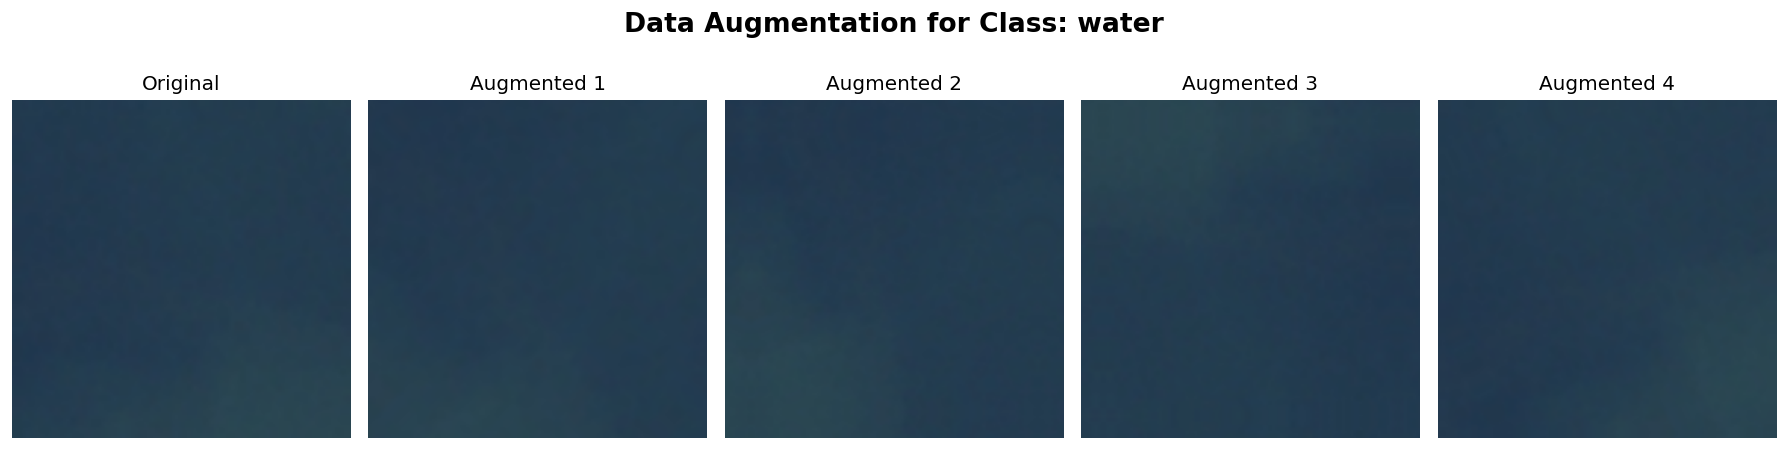

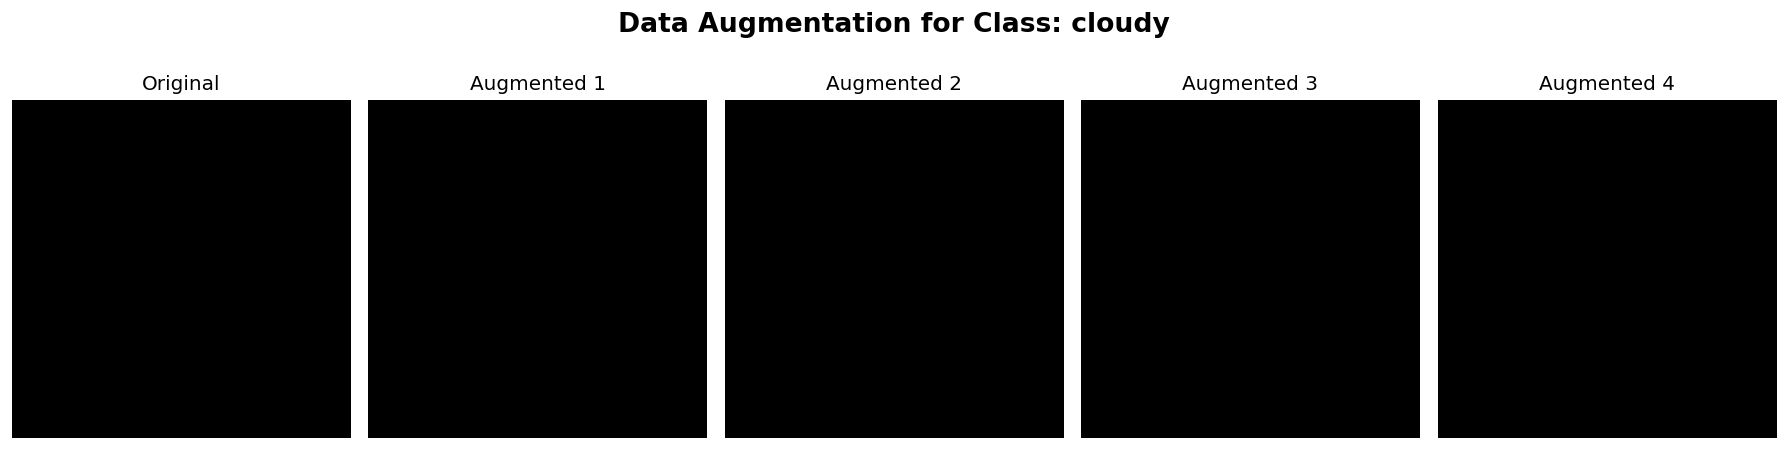

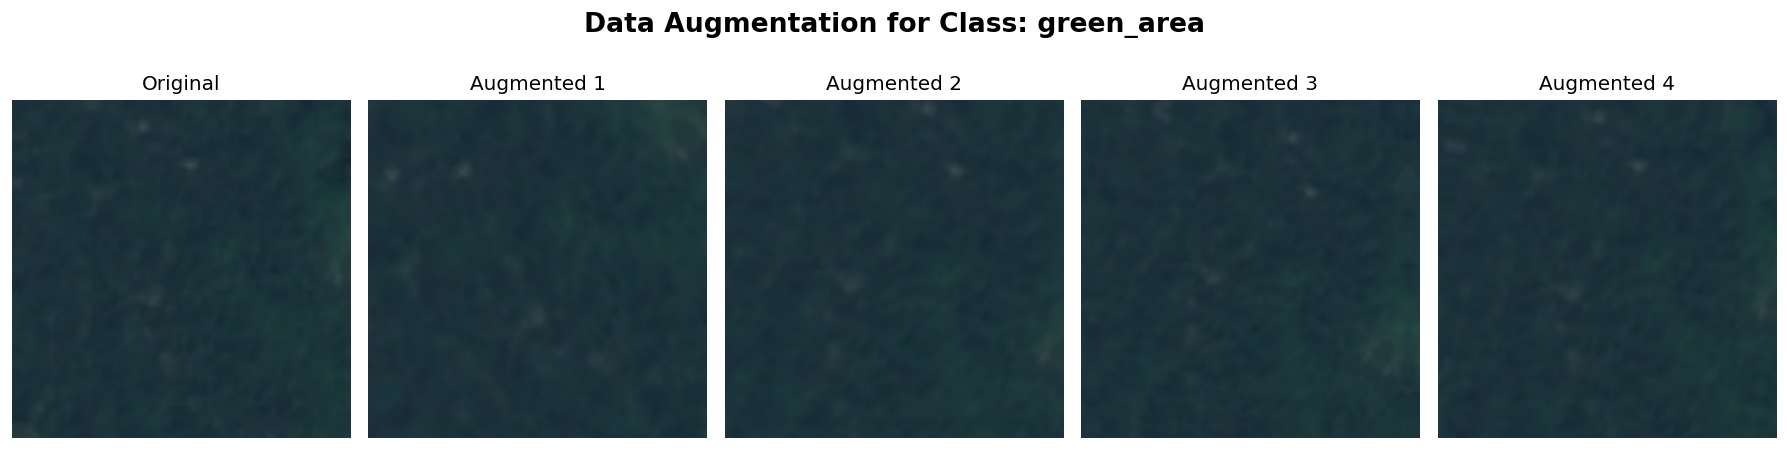

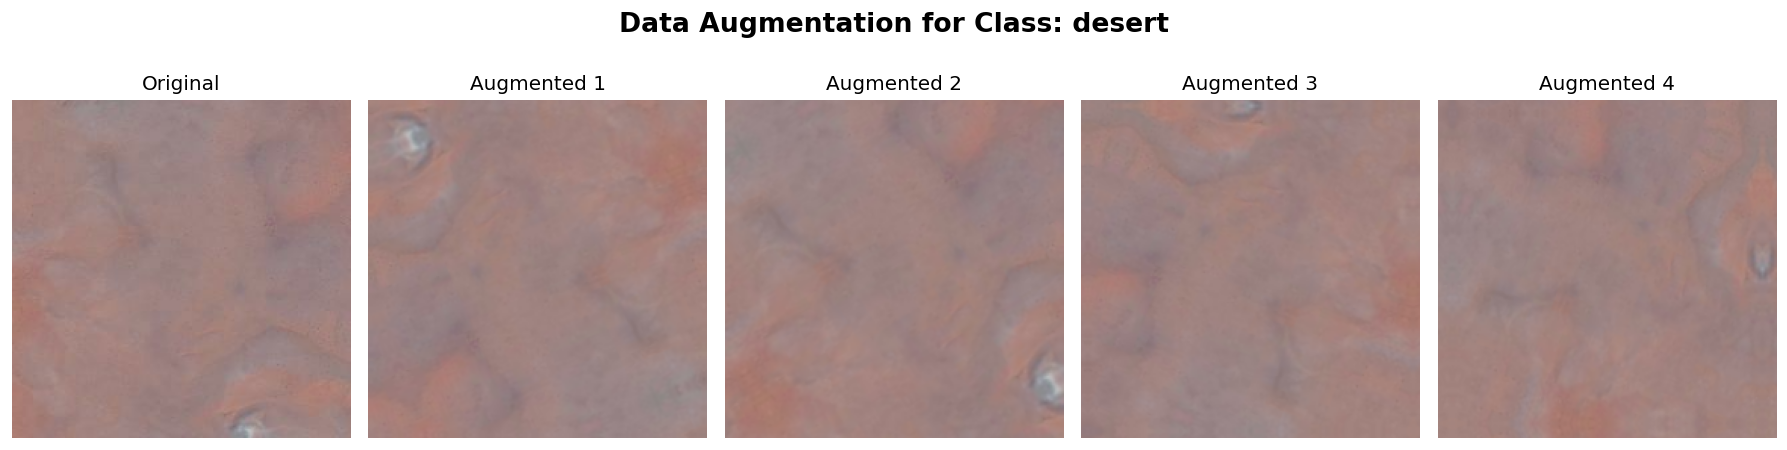

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# --- Apply Augmentation to the Training Dataset ---
try:
    aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    print(" Successfully applied data augmentation to the training dataset.")
except NameError:
    print(" Error: The 'train_dataset' variable is not defined.")
    print(" Please run the data preprocessing script first.")
    aug_train_dataset = None

# --- Visualize the Augmentations for Each Class ---
if aug_train_dataset:
    print("\n🖼️ Generating augmented image samples for each class...")

    # Store one original image per class
    class_images = {}
    for images, labels in train_dataset.unbatch().take(500):  # Increase limit to ensure all classes are covered
        class_index = tf.argmax(labels).numpy() if len(labels.shape) > 0 else labels.numpy()
        class_name = class_names[class_index]
        if class_name not in class_images:
            class_images[class_name] = images.numpy()
        if len(class_images) == len(class_names):
            break

    # Plot original and augmented samples for each class
    for class_name, original_image in class_images.items():
        plt.figure(figsize=(15, 4), dpi=120)
        plt.suptitle(f"Data Augmentation for Class: {class_name}", fontsize=16, fontweight='bold')

        # Show the original image
        plt.subplot(1, 5, 1)
        plt.imshow(original_image.astype("uint8"))
        plt.title("Original", fontsize=12)
        plt.axis("off")

        for i in range(4):
            augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
            plt.subplot(1, 5, i + 2)
            plt.imshow(tf.cast(augmented_image[0], tf.uint8))
            plt.title(f"Augmented {i+1}", fontsize=12)
            plt.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import time
import os


train_dir = 'split_data/train'
validation_dir = 'split_data/validation'
test_dir = 'split_data/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_dataset(ds, augment=False, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

aug_train_ds = prepare_dataset(train_dataset, augment=True, shuffle=True)
val_ds = prepare_dataset(validation_dataset)
test_ds = prepare_dataset(test_dataset)


def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.show()

results = {}
EPOCHS = 3

print("Setup complete. Ready to train models.")


Found 4504 files belonging to 4 classes.
Found 563 files belonging to 4 classes.
Found 564 files belonging to 4 classes.
Setup complete. Ready to train models.



--- Training MLP
Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6370 - loss: 3.5080 - val_accuracy: 0.8028 - val_loss: 0.5775
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7720 - loss: 0.9905 - val_accuracy: 0.7336 - val_loss: 0.6143
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8270 - loss: 0.3984 - val_accuracy: 0.8934 - val_loss: 0.2646


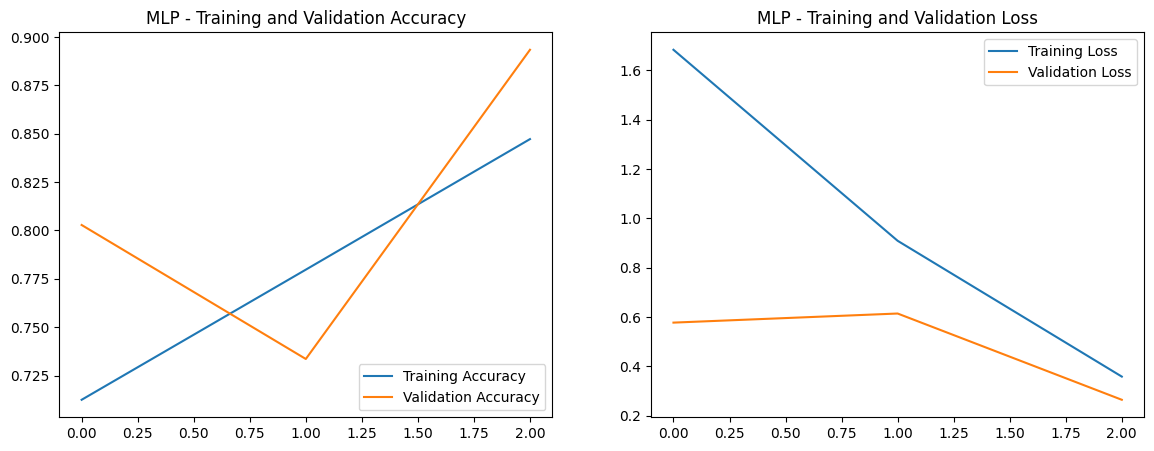

In [ ]:
# MLP
print("\n--- Training MLP")
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mlp = mlp_model.fit(prepare_dataset(train_dataset, shuffle=True), epochs=EPOCHS, validation_data=val_ds, verbose=1)
plot_history(history_mlp, "MLP")
loss, acc = mlp_model.evaluate(test_ds, verbose=0)
results['MLP'] = {'loss': loss, 'accuracy': acc, 'history': history_mlp, 'model': mlp_model}


--- Training  CNN ---
Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.7481 - loss: 1.3450 - val_accuracy: 0.9147 - val_loss: 0.1853
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 71s 203ms/step - accuracy: 0.8999 - loss: 0.2353 - val_accuracy: 0.9130 - val_loss: 0.1927
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.9105 - loss: 0.1868 - val_accuracy: 0.9432 - val_loss: 0.1654


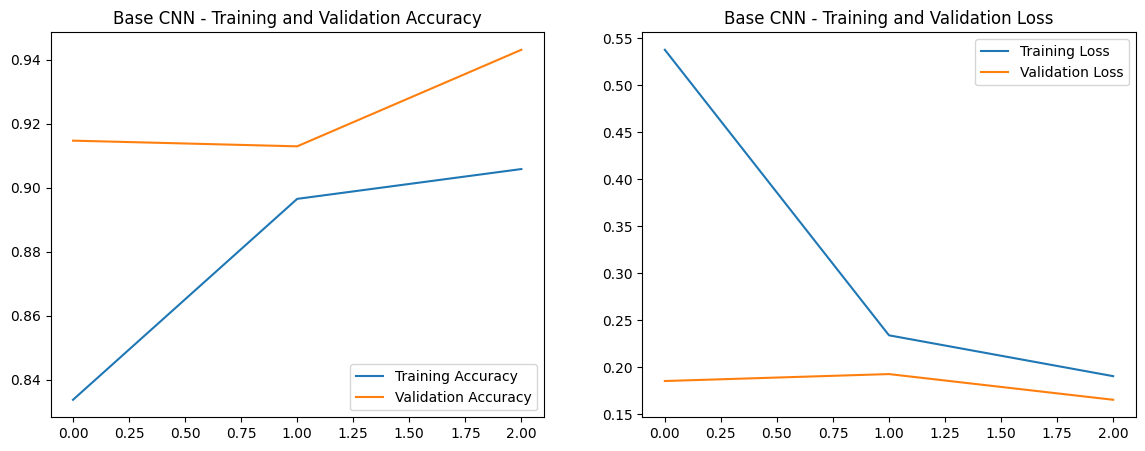

In [ ]:
#Base CNN Model
print("--- Training  CNN ---")
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(aug_train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)
plot_history(history_cnn, "Base CNN")
loss, acc = cnn_model.evaluate(test_ds, verbose=0)
results[' CNN'] = {'loss': loss, 'accuracy': acc, 'history': history_cnn, 'model': cnn_model}



--- Training VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 343ms/step - accuracy: 0.2552 - loss: 1.7518 - val_accuracy: 0.2664 - val_loss: 1.4242
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.2698 - loss: 1.4093 - val_accuracy: 0.2664 - val_loss: 1.3903
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.2652 - loss: 1.3891 - val_accuracy: 0.2664 - val_loss: 1.3824


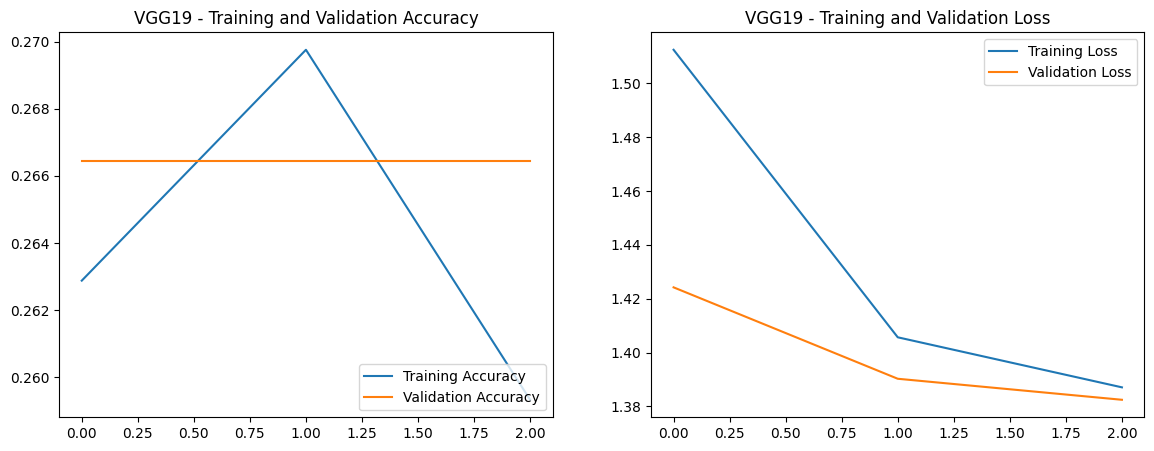

In [ ]:
# VGG19
print("\n--- Training VGG19")
vgg19_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(tf.keras.applications.vgg19.preprocess_input, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
vgg19_model.layers[1].trainable = False
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg19 = vgg19_model.fit(prepare_dataset(train_dataset, shuffle=True), epochs=EPOCHS, validation_data=val_ds, verbose=1)
plot_history(history_vgg19, "VGG19")
loss, acc = vgg19_model.evaluate(test_ds, verbose=0)
results['VGG19'] = {'loss': loss, 'accuracy': acc, 'history': history_vgg19, 'model': vgg19_model}


--- Training Xception ---
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.8162 - loss: 0.7602 - val_accuracy: 0.9556 - val_loss: 0.2164
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.9652 - loss: 0.1765 - val_accuracy: 0.9769 - val_loss: 0.1261
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.9738 - loss: 0.1177 - val_accuracy: 0.9822 - val_loss: 0.0956


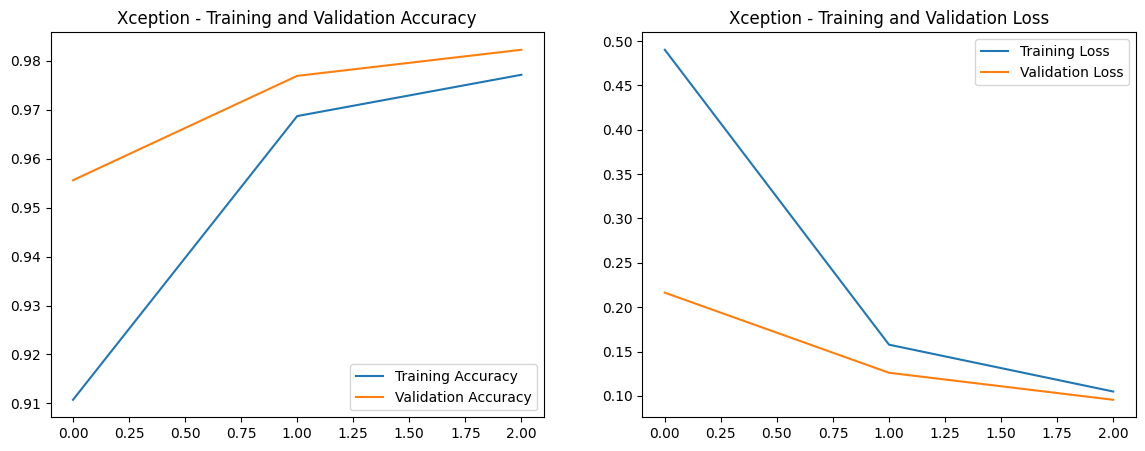

In [ ]:
# Xception (Transfer Learning)
print("\n--- Training Xception ---")
base_model_xception = tf.keras.applications.Xception(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model_xception.trainable = False
xception_model = tf.keras.Sequential([
    base_model_xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_xception = xception_model.fit(prepare_dataset(train_dataset, shuffle=True), epochs=EPOCHS, validation_data=val_ds, verbose=1)
plot_history(history_xception, "Xception")
loss, acc = xception_model.evaluate(test_ds, verbose=0)
results['Xception'] = {'loss': loss, 'accuracy': acc, 'history': history_xception, 'model': xception_model}



--- Training BetaX ---
Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 71s 359ms/step - accuracy: 0.8938 - loss: 0.3516 - val_accuracy: 0.9911 - val_loss: 0.0381
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 62s 275ms/step - accuracy: 0.9928 - loss: 0.0289 - val_accuracy: 0.9947 - val_loss: 0.0176
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.9955 - loss: 0.0170 - val_accuracy: 0.9929 - val_loss: 0.0280


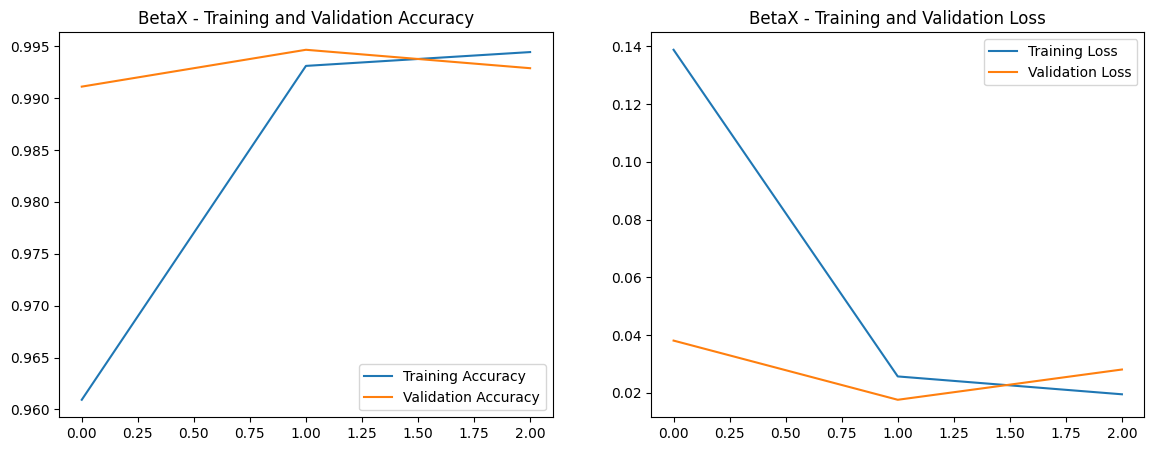

In [ ]:
print("\n--- Training BetaX ---")

base_model_betax = tf.keras.applications.Xception(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                  include_top=False,
                                                  weights='imagenet')

#  Unfreeze the top layers of the model to enable fine-tuning
base_model_betax.trainable = True

#  finetune from layer 100 onwards. Layers before this will remain frozen.
fine_tune_at = 100
for layer in base_model_betax.layers[:fine_tune_at]:
    layer.trainable = False

#  Build the final model architecture
betax_model = tf.keras.Sequential([
    base_model_betax,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5), # Add dropout for regularization
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with a low learning rate
betax_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_betax = betax_model.fit(aug_train_ds,
                                epochs=3,
                                validation_data=val_ds,
                                verbose=1)

plot_history(history_betax, "BetaX")
loss, acc = betax_model.evaluate(test_ds, verbose=0)
results['BetaX'] = {'loss': loss, 'accuracy': acc, 'history': history_betax, 'model': betax_model}


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step

--- Final Model Performance ---
   Model Train Accuracy (%) Validation Accuracy (%) Test Accuracy (%) Test Loss F1 Score (%)
   VGG19             25.93%                  26.64%            26.60%    1.3831       11.17%
     MLP             84.72%                  89.34%            88.12%    0.2701       87.57%
     CNN             90.59%                  94.32%            93.97%    0.1581       93.96%
Xception             97.71%                  98.22%            97.34%    0.0910       97.34%
   BetaX             99.44%                  99.29%            99.29%    0.0215       99.29%


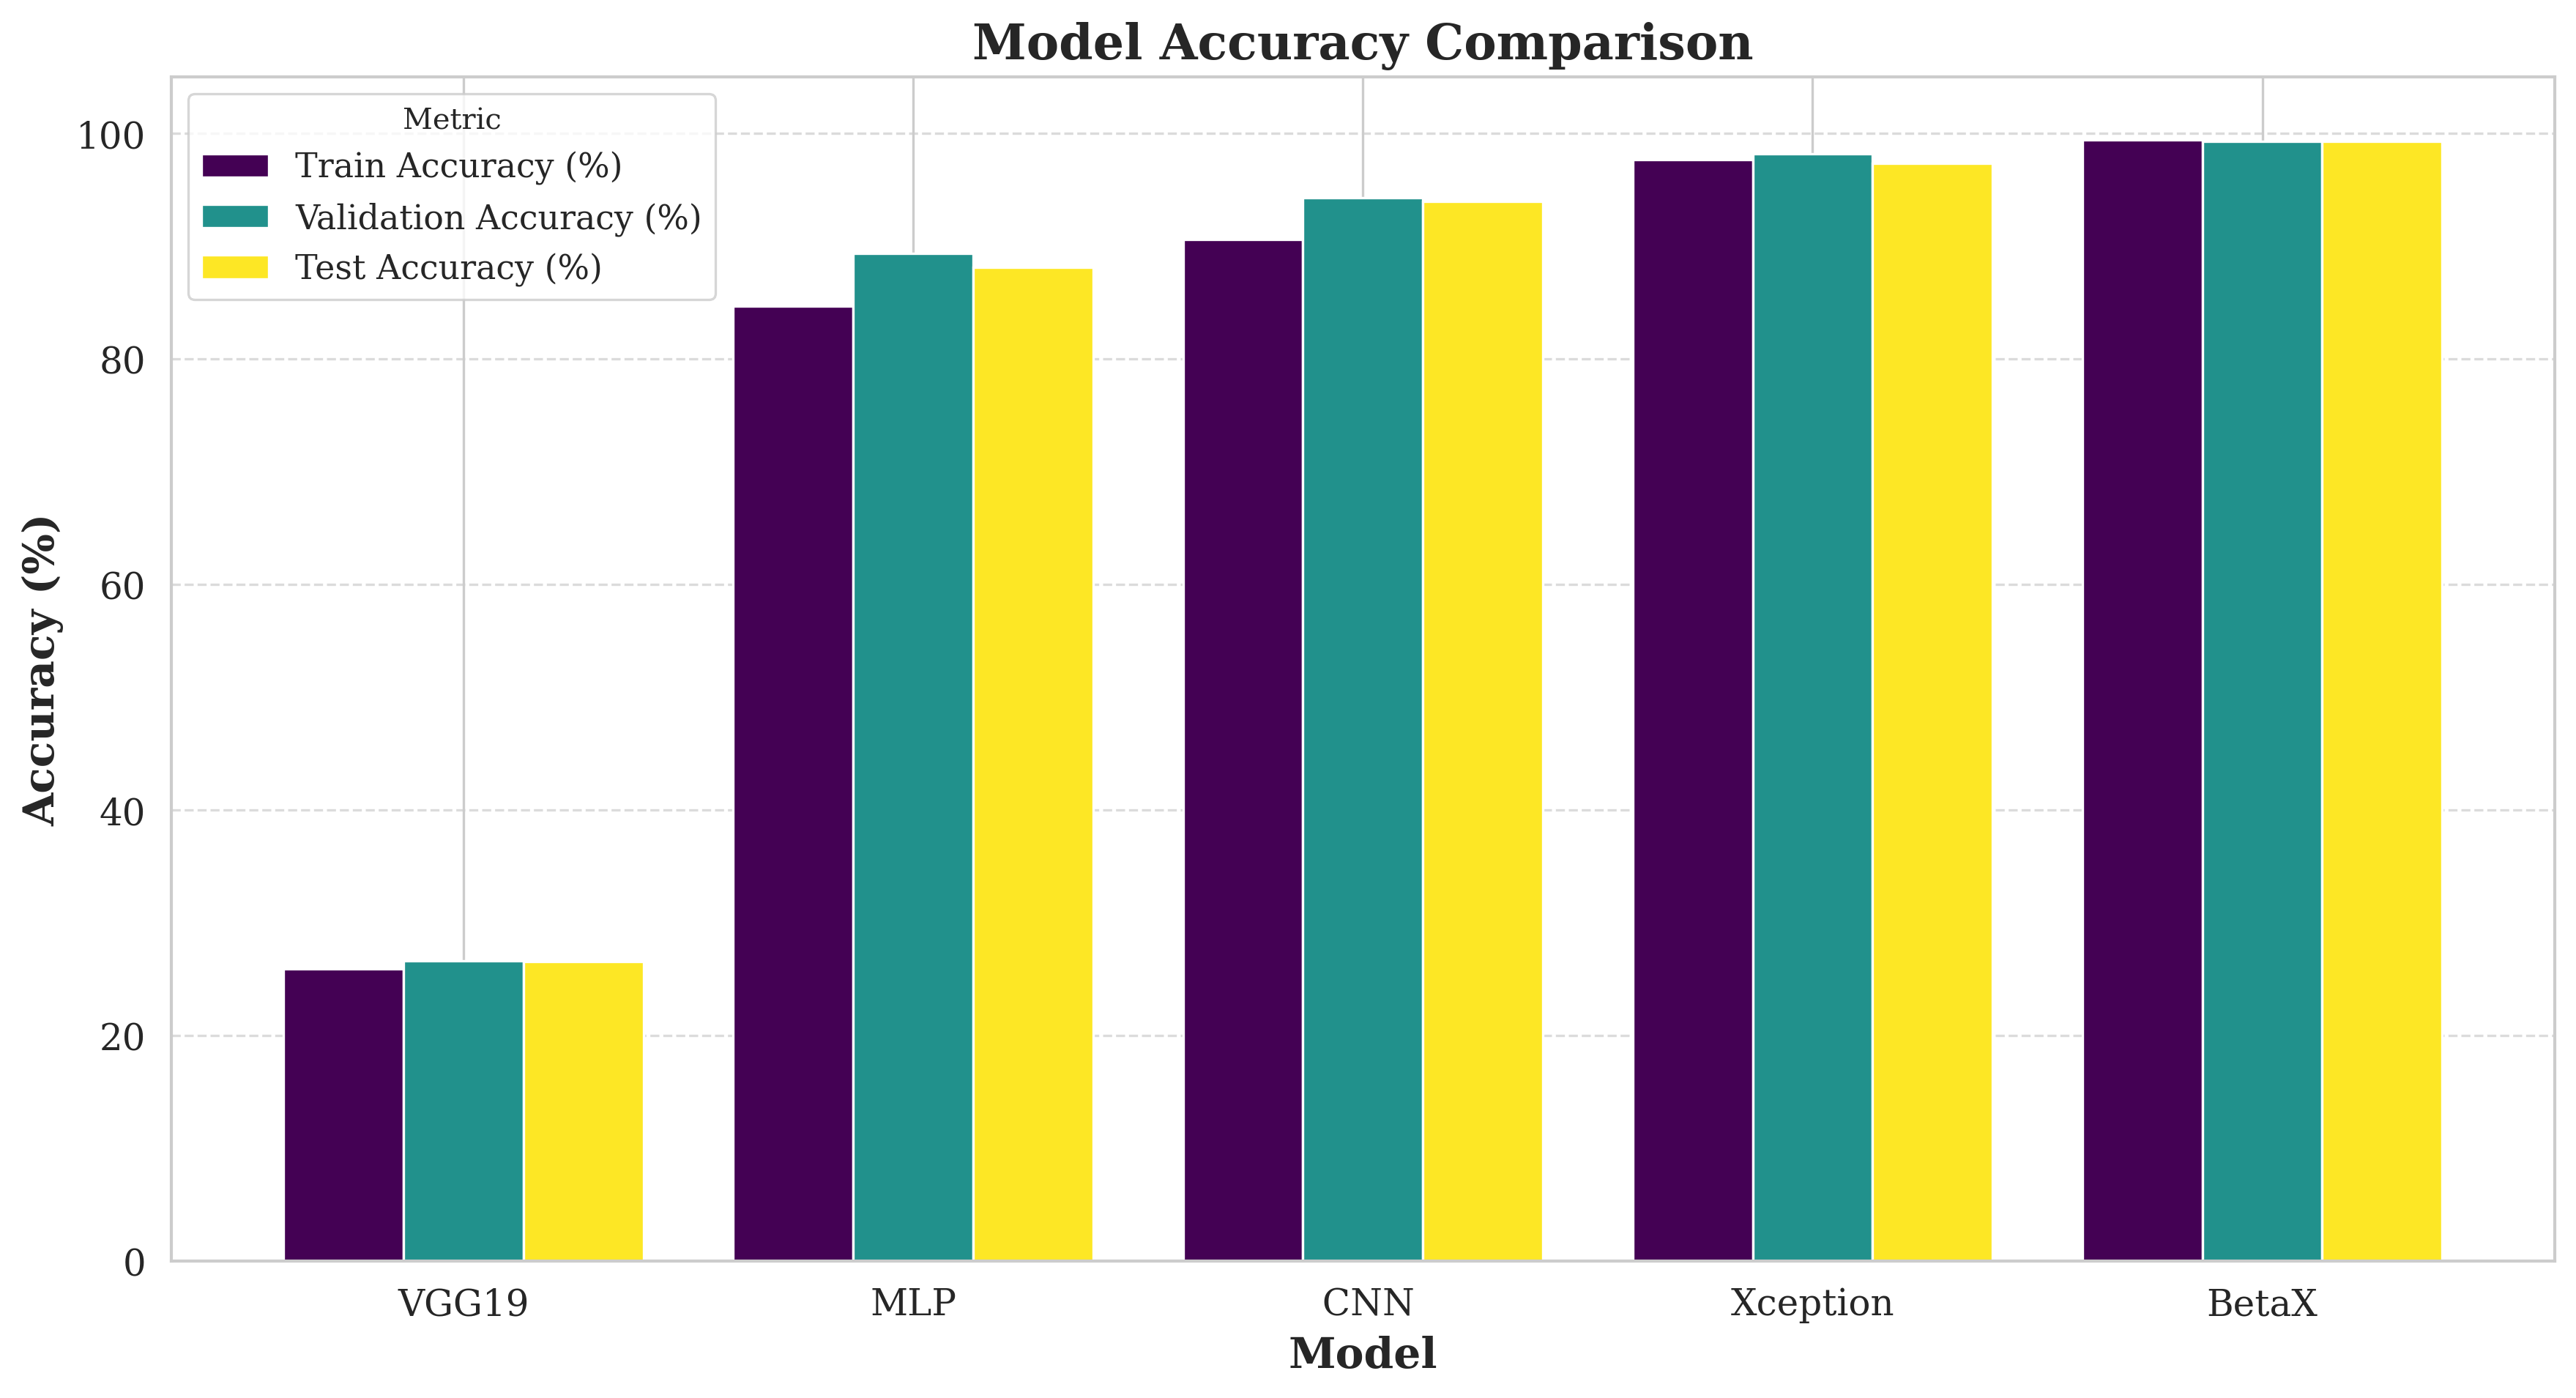

In [ ]:
from sklearn.metrics import f1_score

results_list = []
for name, res in results.items():
    test_acc = res['accuracy'] * 100
    if res['history']:
        train_acc = res['history'].history['accuracy'][-1] * 100
        val_acc = res['history'].history['val_accuracy'][-1] * 100
    else:
        train_acc, val_acc = float('nan'), float('nan')

    # Calculate F1 score
    model = res['model']
    y_pred_probs = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true_classes = np.argmax(y_true, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted') * 100

    results_list.append([name, train_acc, val_acc, test_acc, res['loss'], f1])


results_df = pd.DataFrame(results_list, columns=['Model', 'Train Accuracy (%)', 'Validation Accuracy (%)', 'Test Accuracy (%)', 'Test Loss', 'F1 Score (%)'])

results_df = results_df.sort_values(by='Test Accuracy (%)')

print("\n--- Final Model Performance ---")
display_df = results_df.copy()
for col in ['Train Accuracy (%)', 'Validation Accuracy (%)', 'Test Accuracy (%)', 'F1 Score (%)']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}%" if pd.notna(x) else "N/A")
display_df['Test Loss'] = display_df['Test Loss'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
print(display_df.to_string(index=False))

results_df.set_index('Model')[['Train Accuracy (%)', 'Validation Accuracy (%)', 'Test Accuracy (%)']].plot(
    kind='bar',
    figsize=(14, 7),
    title="Model Accuracy Comparison",
    rot=0,
    width=0.8,
    colormap='viridis'
)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()


--- Analysis for Best Model: BetaX ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


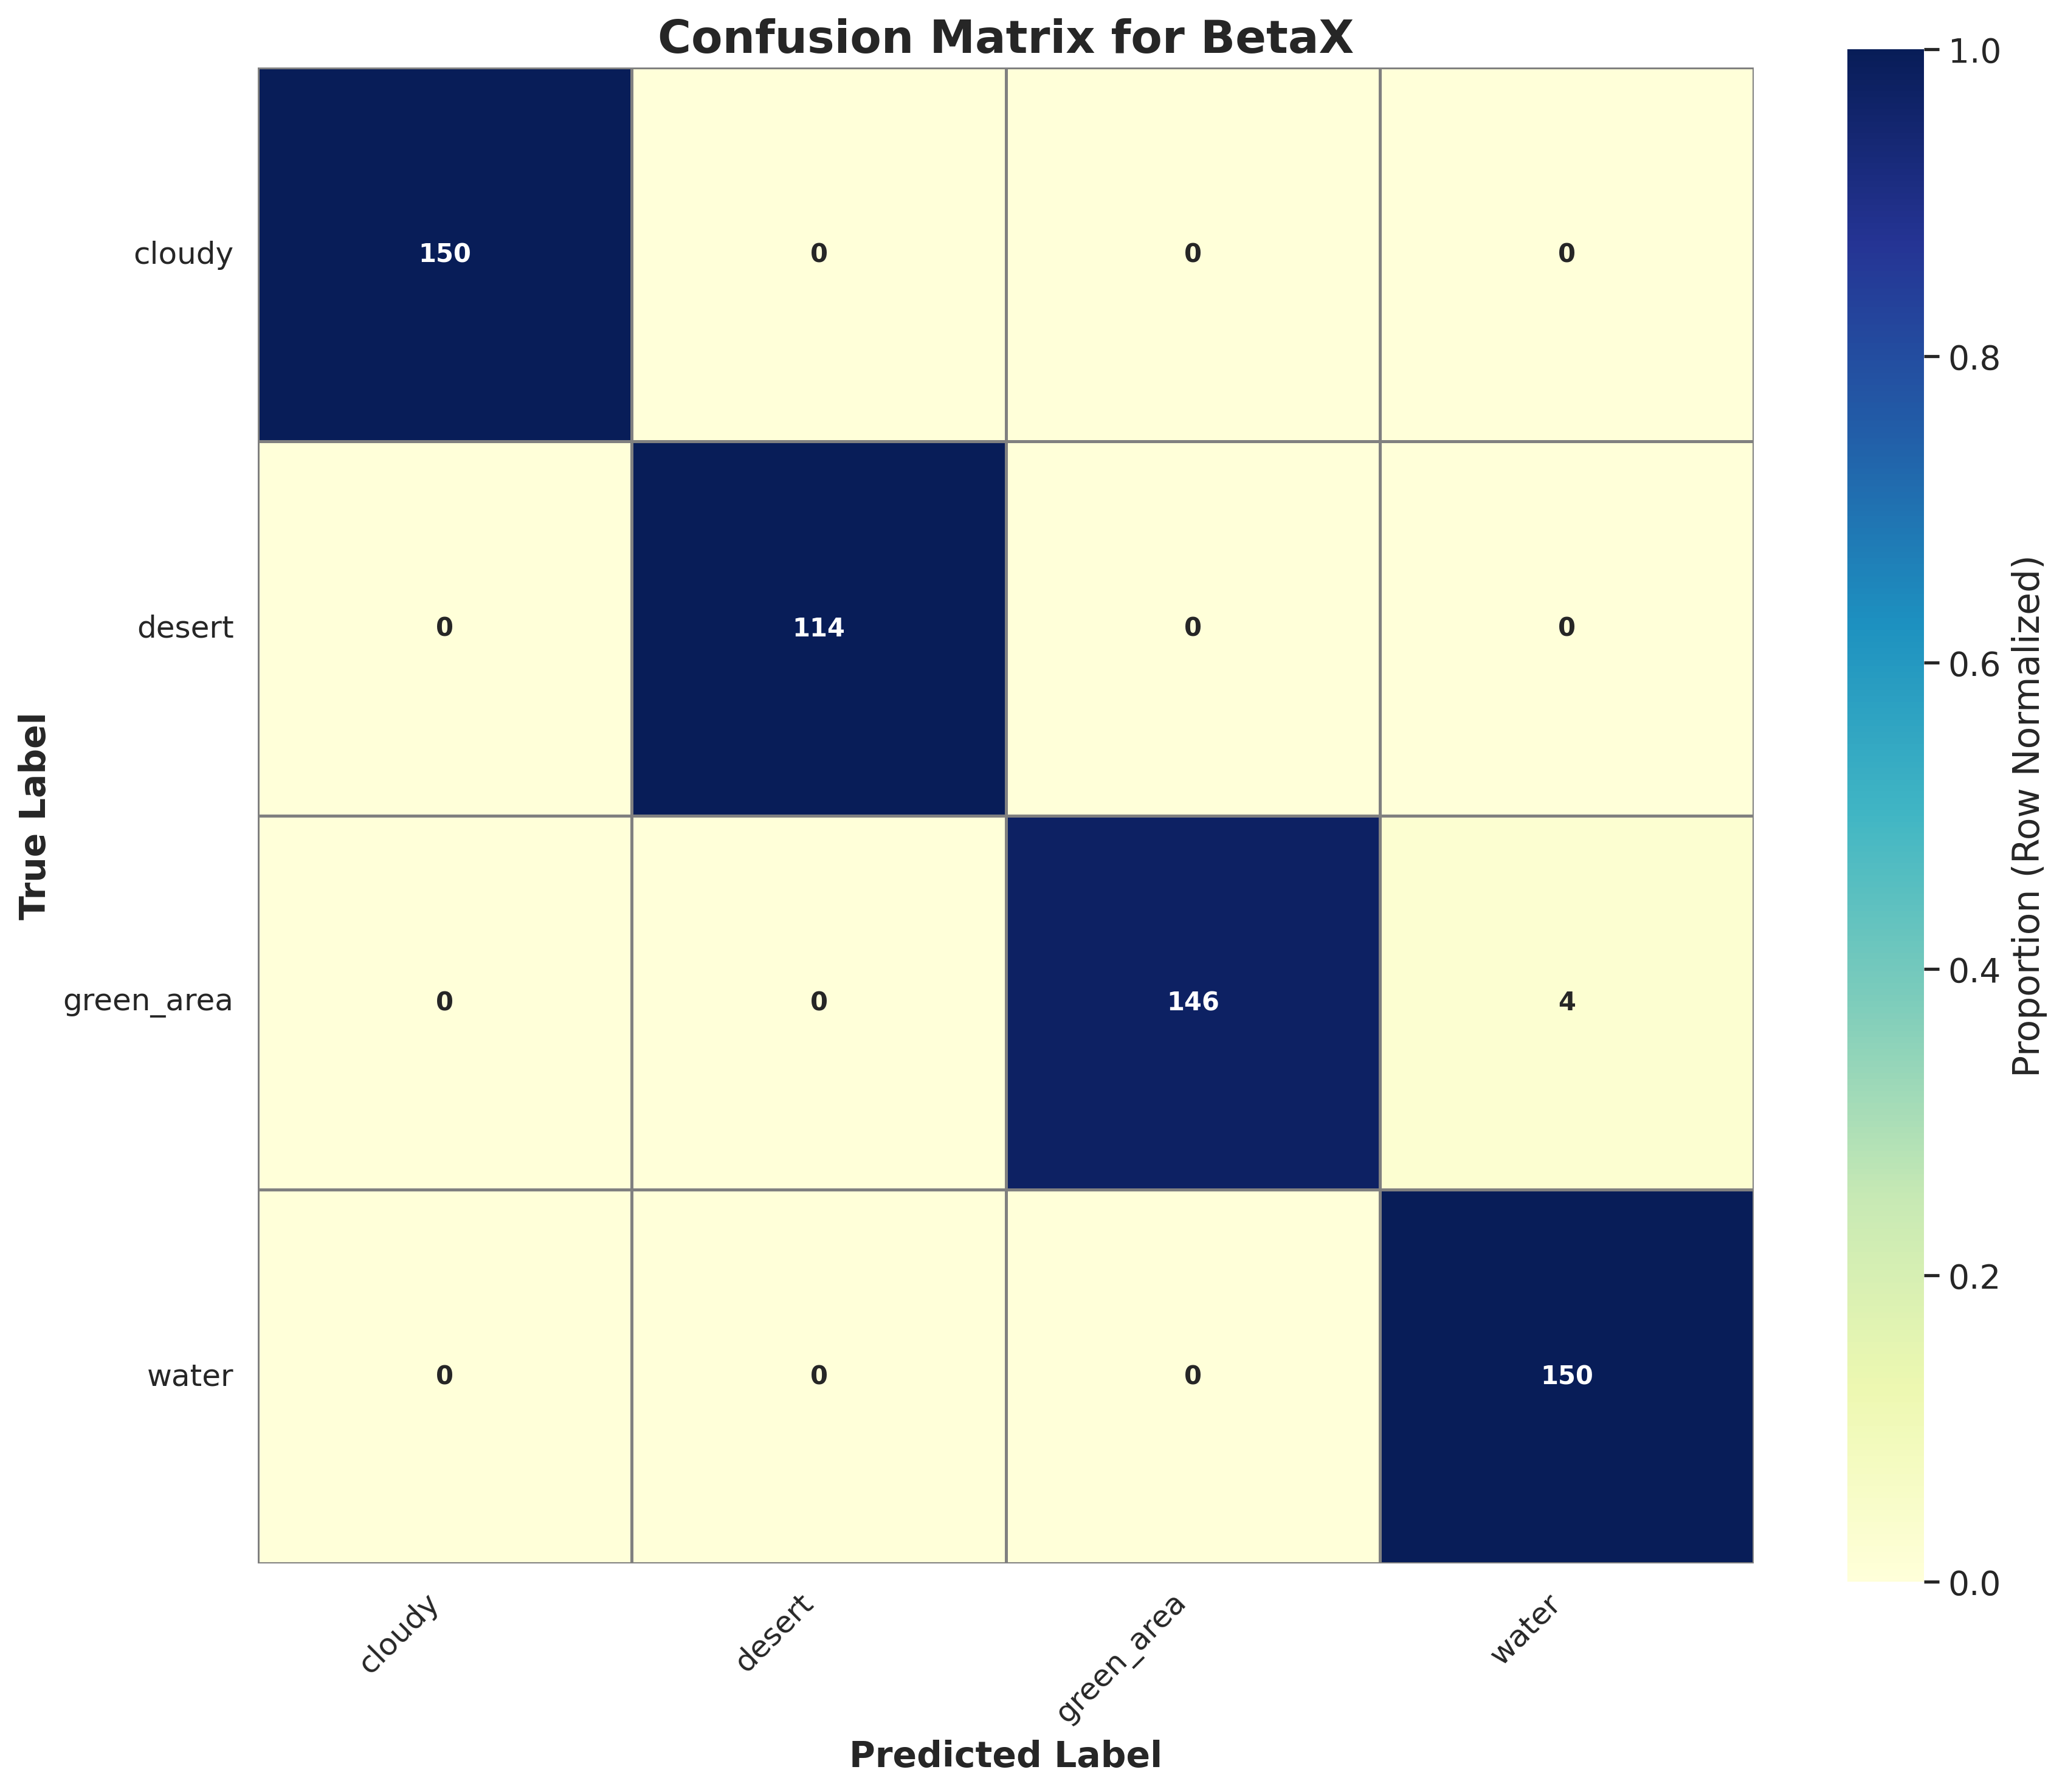


--- Classification Report ---
              precision    recall  f1-score   support

      cloudy     1.0000    1.0000    1.0000       150
      desert     1.0000    1.0000    1.0000       114
  green_area     1.0000    0.9733    0.9865       150
       water     0.9740    1.0000    0.9868       150

    accuracy                         0.9929       564
   macro avg     0.9935    0.9933    0.9933       564
weighted avg     0.9931    0.9929    0.9929       564



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model_name = results_df.sort_values(by='Test Accuracy (%)', ascending=False).iloc[0]['Model']
print(f"\n--- Analysis for Best Model: {best_model_name} ---")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

if best_model_name == 'VGG19':
    y_pred_classes = results['VGG19']['preds']
else:
    best_model = results[best_model_name]['model']
    y_pred_probs = best_model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10), dpi=300)
sns.set(font_scale=1.2)
ax = sns.heatmap(
    cm_normalized,
    annot=cm,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.8,
    linecolor='gray',
    square=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 10, "weight": "bold"},
    cbar_kws={'label': 'Proportion (Row Normalized)'}
)

plt.title(f'Confusion Matrix for {best_model_name}', fontsize=18, weight='bold')
plt.xlabel('Predicted Label', fontsize=14, weight='bold')
plt.ylabel('True Label', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4,
    output_dict=False
)

print("\n--- Classification Report ---")
print(report)


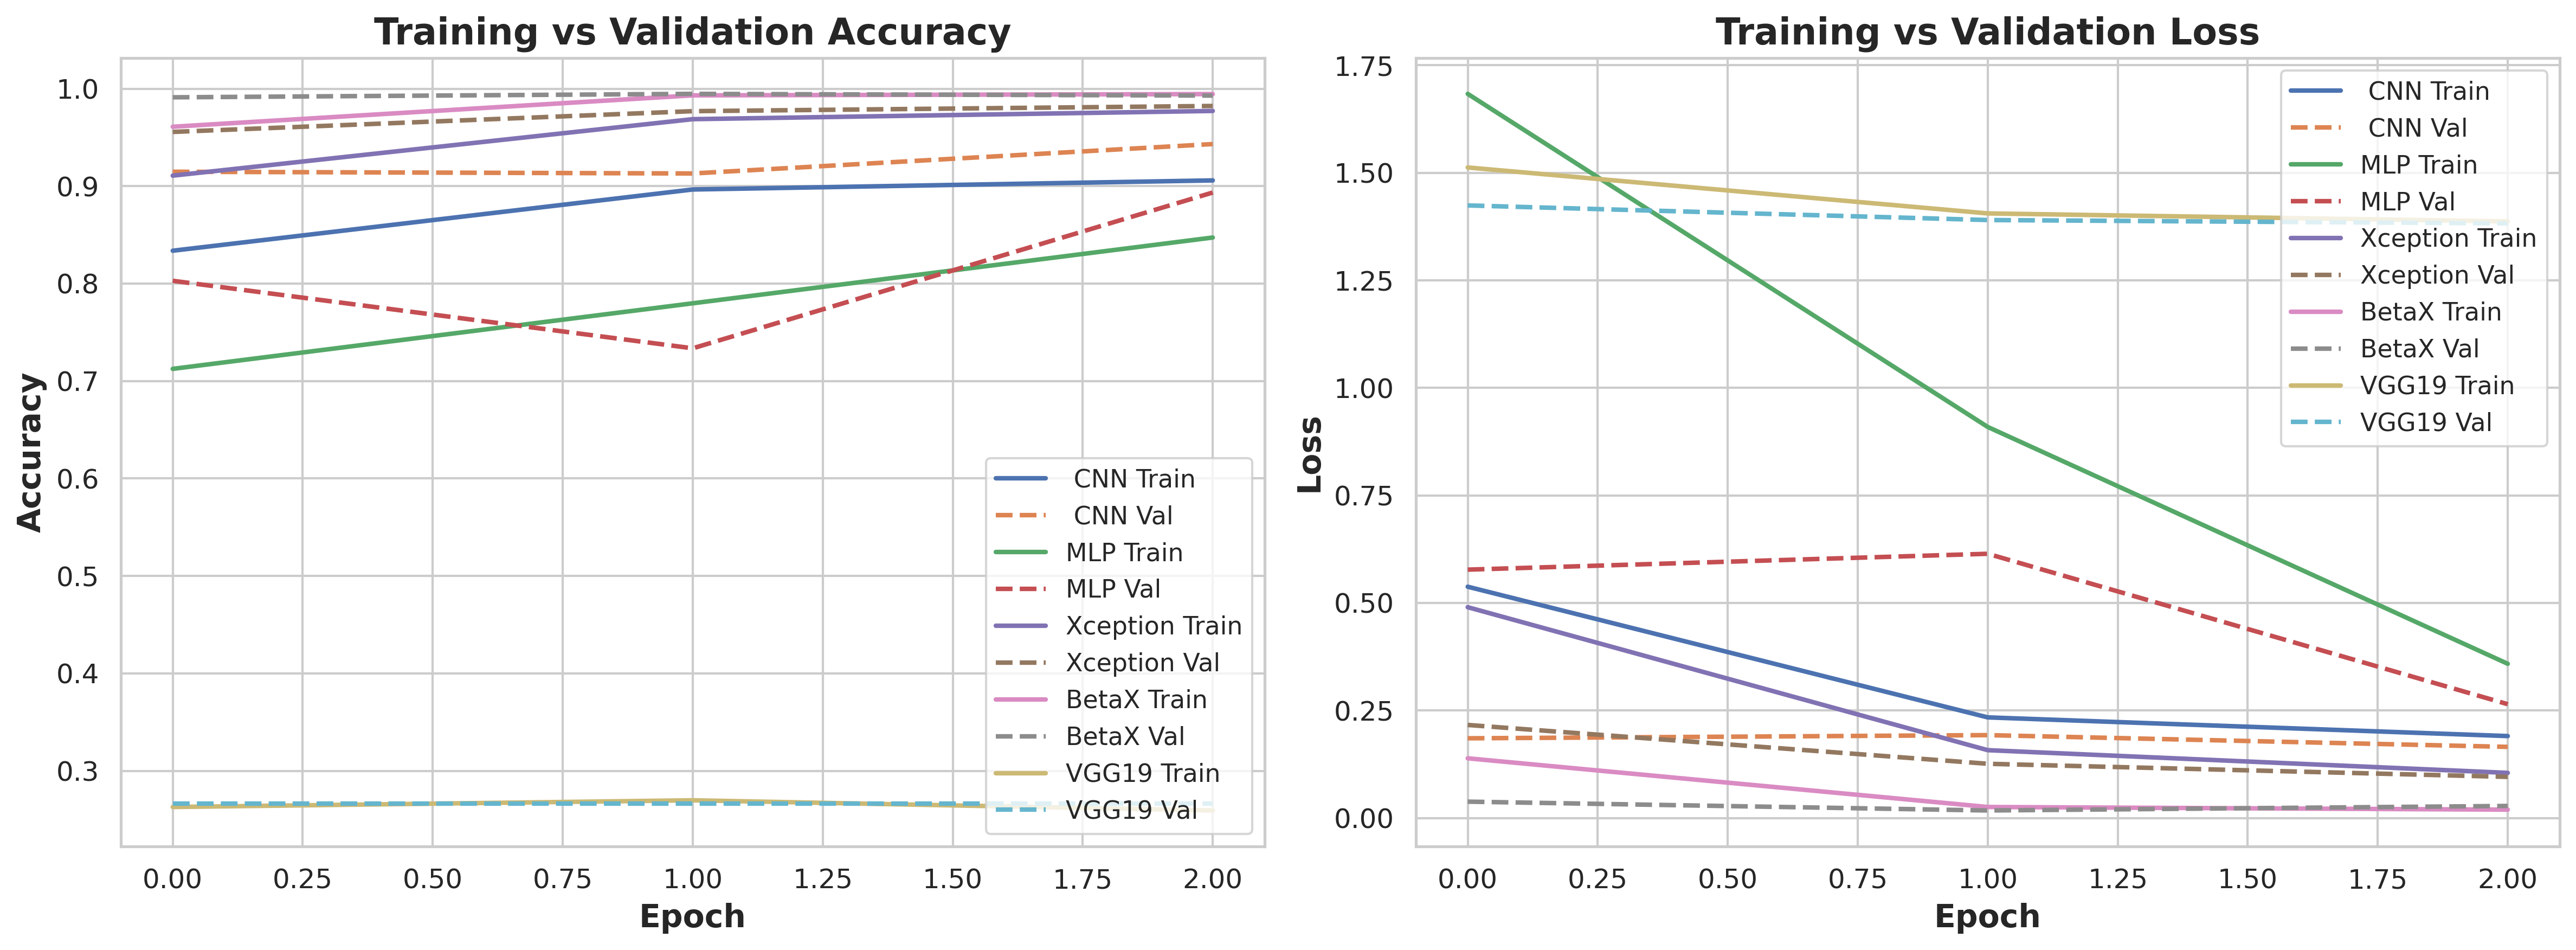

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme for publication-ready aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'legend.fontsize': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# --- Training & Validation Accuracy ---
for name, res in results.items():
    if 'history' in res and res['history']:
        axes[0].plot(res['history'].history['accuracy'], label=f'{name} Train', linewidth=2)
        axes[0].plot(res['history'].history['val_accuracy'], label=f'{name} Val', linestyle='--', linewidth=2)

axes[0].set_title('Training vs Validation Accuracy', weight='bold')
axes[0].set_xlabel('Epoch', weight='bold')
axes[0].set_ylabel('Accuracy', weight='bold')
axes[0].legend(loc='lower right', frameon=True)
axes[0].grid(True)

# --- Training & Validation Loss ---
for name, res in results.items():
    if 'history' in res and res['history']:
        axes[1].plot(res['history'].history['loss'], label=f'{name} Train', linewidth=2)
        axes[1].plot(res['history'].history['val_loss'], label=f'{name} Val', linestyle='--', linewidth=2)

axes[1].set_title('Training vs Validation Loss', weight='bold')
axes[1].set_xlabel('Epoch', weight='bold')
axes[1].set_ylabel('Loss', weight='bold')
axes[1].legend(loc='upper right', frameon=True)
axes[1].grid(True)

# Final layout adjustments
plt.tight_layout()
plt.show()


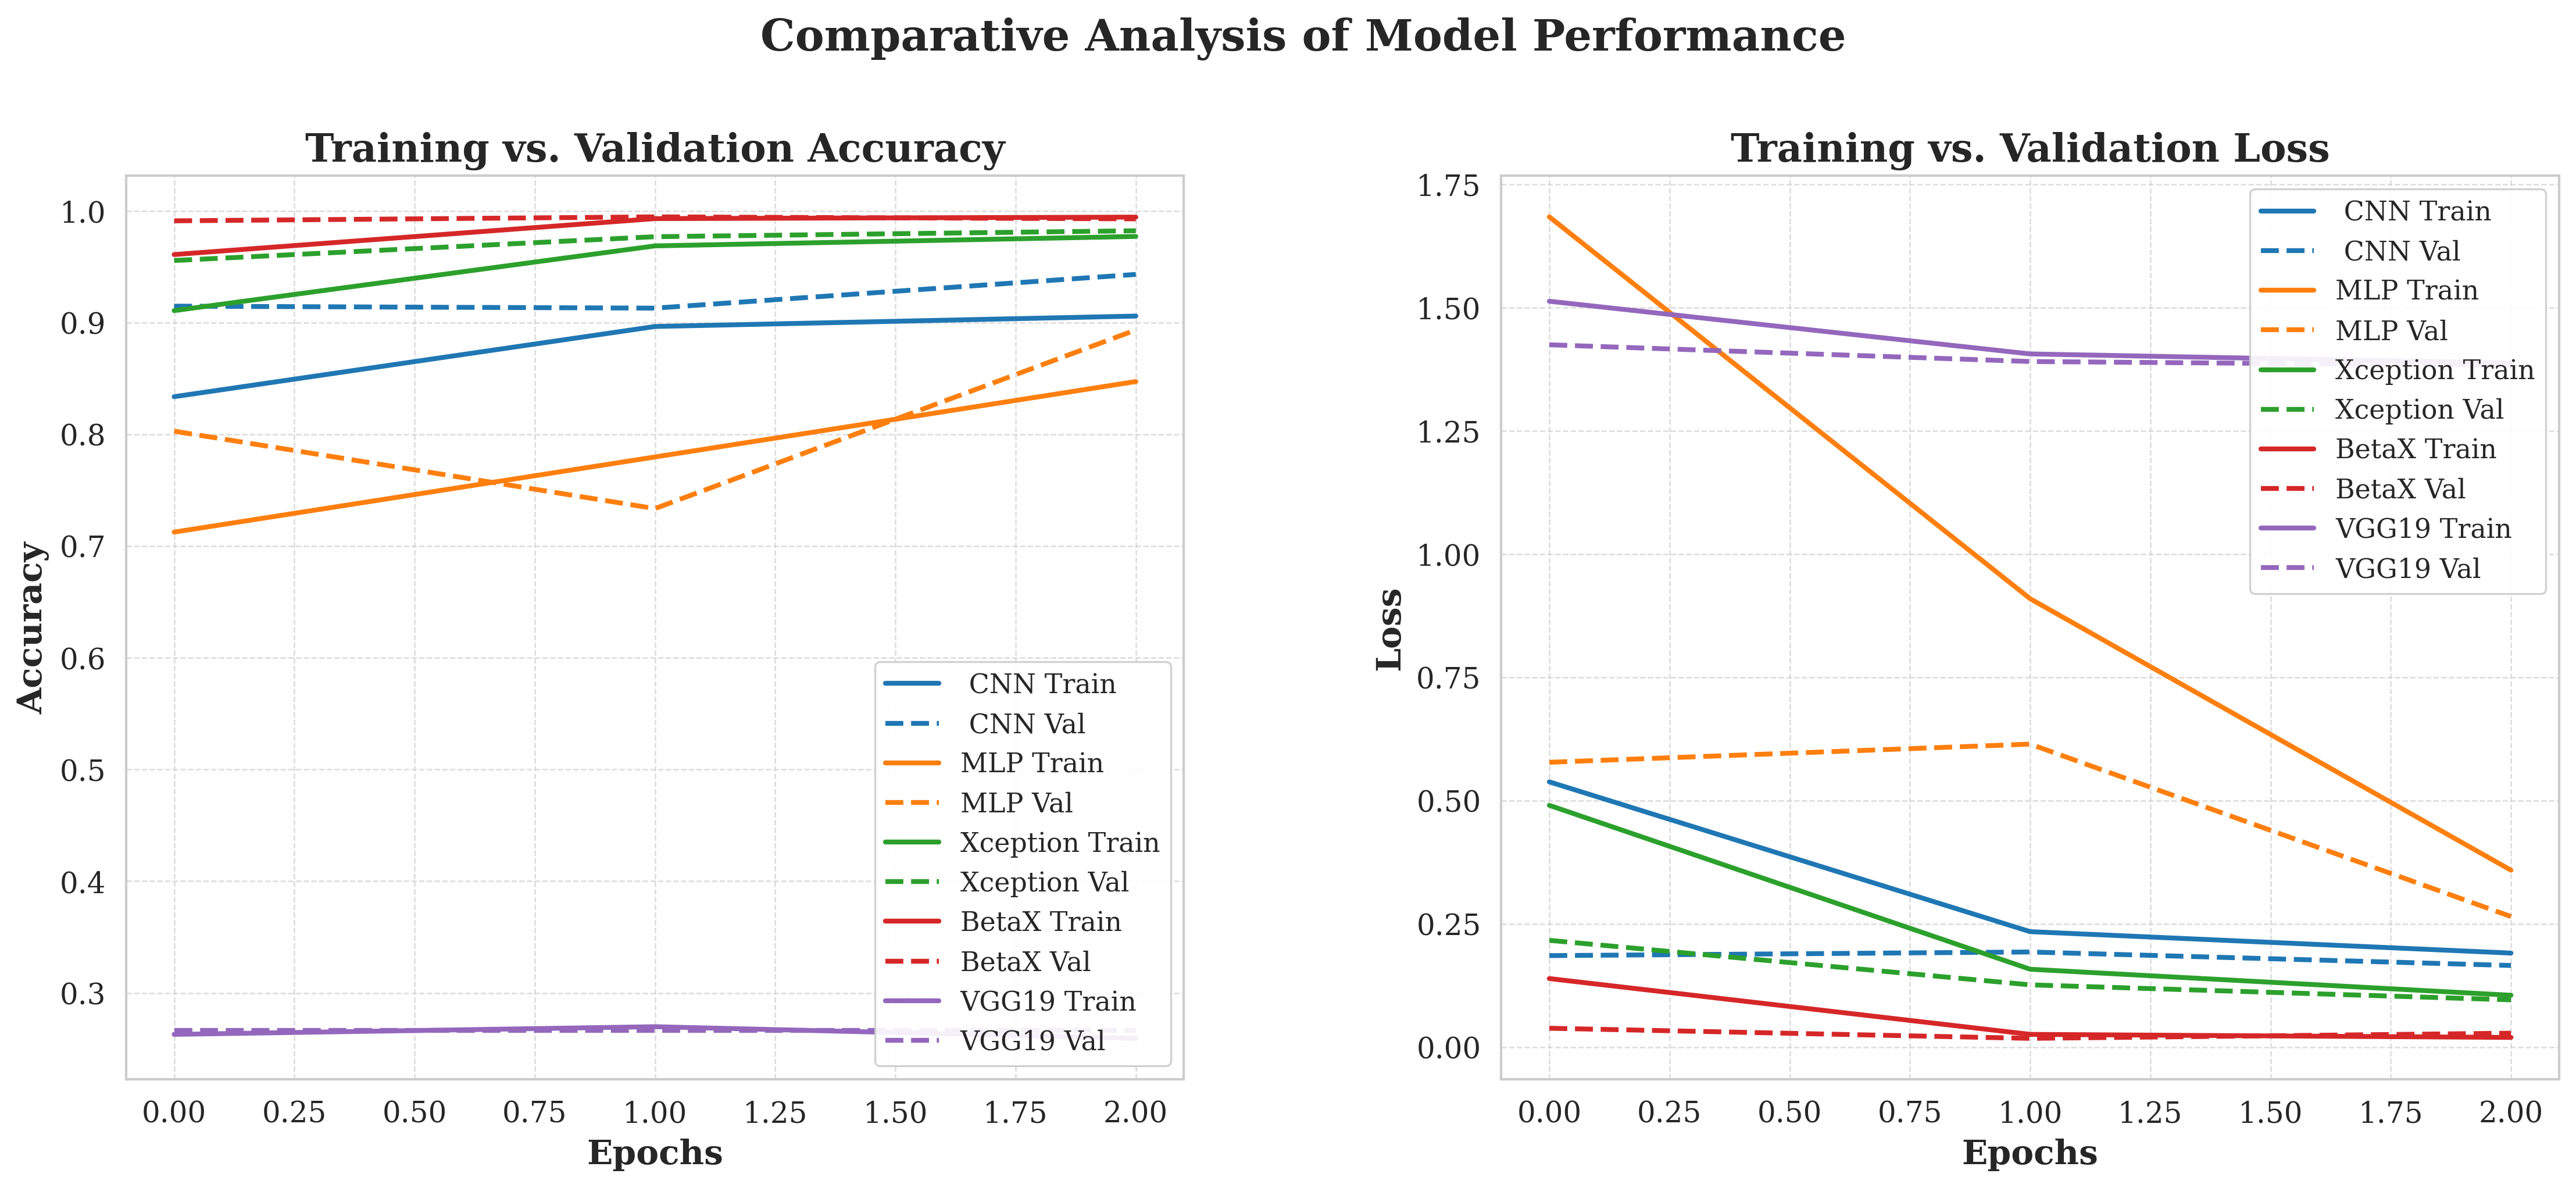

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper")
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'legend.fontsize': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'figure.dpi': 300
})

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.subplots_adjust(top=0.85, wspace=0.3)

palette = sns.color_palette("tab10", n_colors=len(results))

for i, (model_name, res) in enumerate(results.items()):
    if 'history' in res and res['history']:
        axes[0].plot(res['history'].history['accuracy'], label=f'{model_name} Train', color=palette[i])
        axes[0].plot(res['history'].history['val_accuracy'], label=f'{model_name} Val', color=palette[i], linestyle='--')

axes[0].set_title('Training vs. Validation Accuracy', weight='bold')
axes[0].set_xlabel('Epochs', weight='bold')
axes[0].set_ylabel('Accuracy', weight='bold')
axes[0].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
axes[0].legend(loc='lower right', frameon=True, fancybox=True, framealpha=0.9)

for i, (model_name, res) in enumerate(results.items()):
    if 'history' in res and res['history']:
        axes[1].plot(res['history'].history['loss'], label=f'{model_name} Train', color=palette[i])
        axes[1].plot(res['history'].history['val_loss'], label=f'{model_name} Val', color=palette[i], linestyle='--')

axes[1].set_title('Training vs. Validation Loss', weight='bold')
axes[1].set_xlabel('Epochs', weight='bold')
axes[1].set_ylabel('Loss', weight='bold')
axes[1].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
axes[1].legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.9)

fig.suptitle('Comparative Analysis of Model Performance', fontsize=18, weight='bold')

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step


/tmp/ipython-input-39-2884288810.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='F1 Score', y='Model', data=f1_df, palette='viridis')


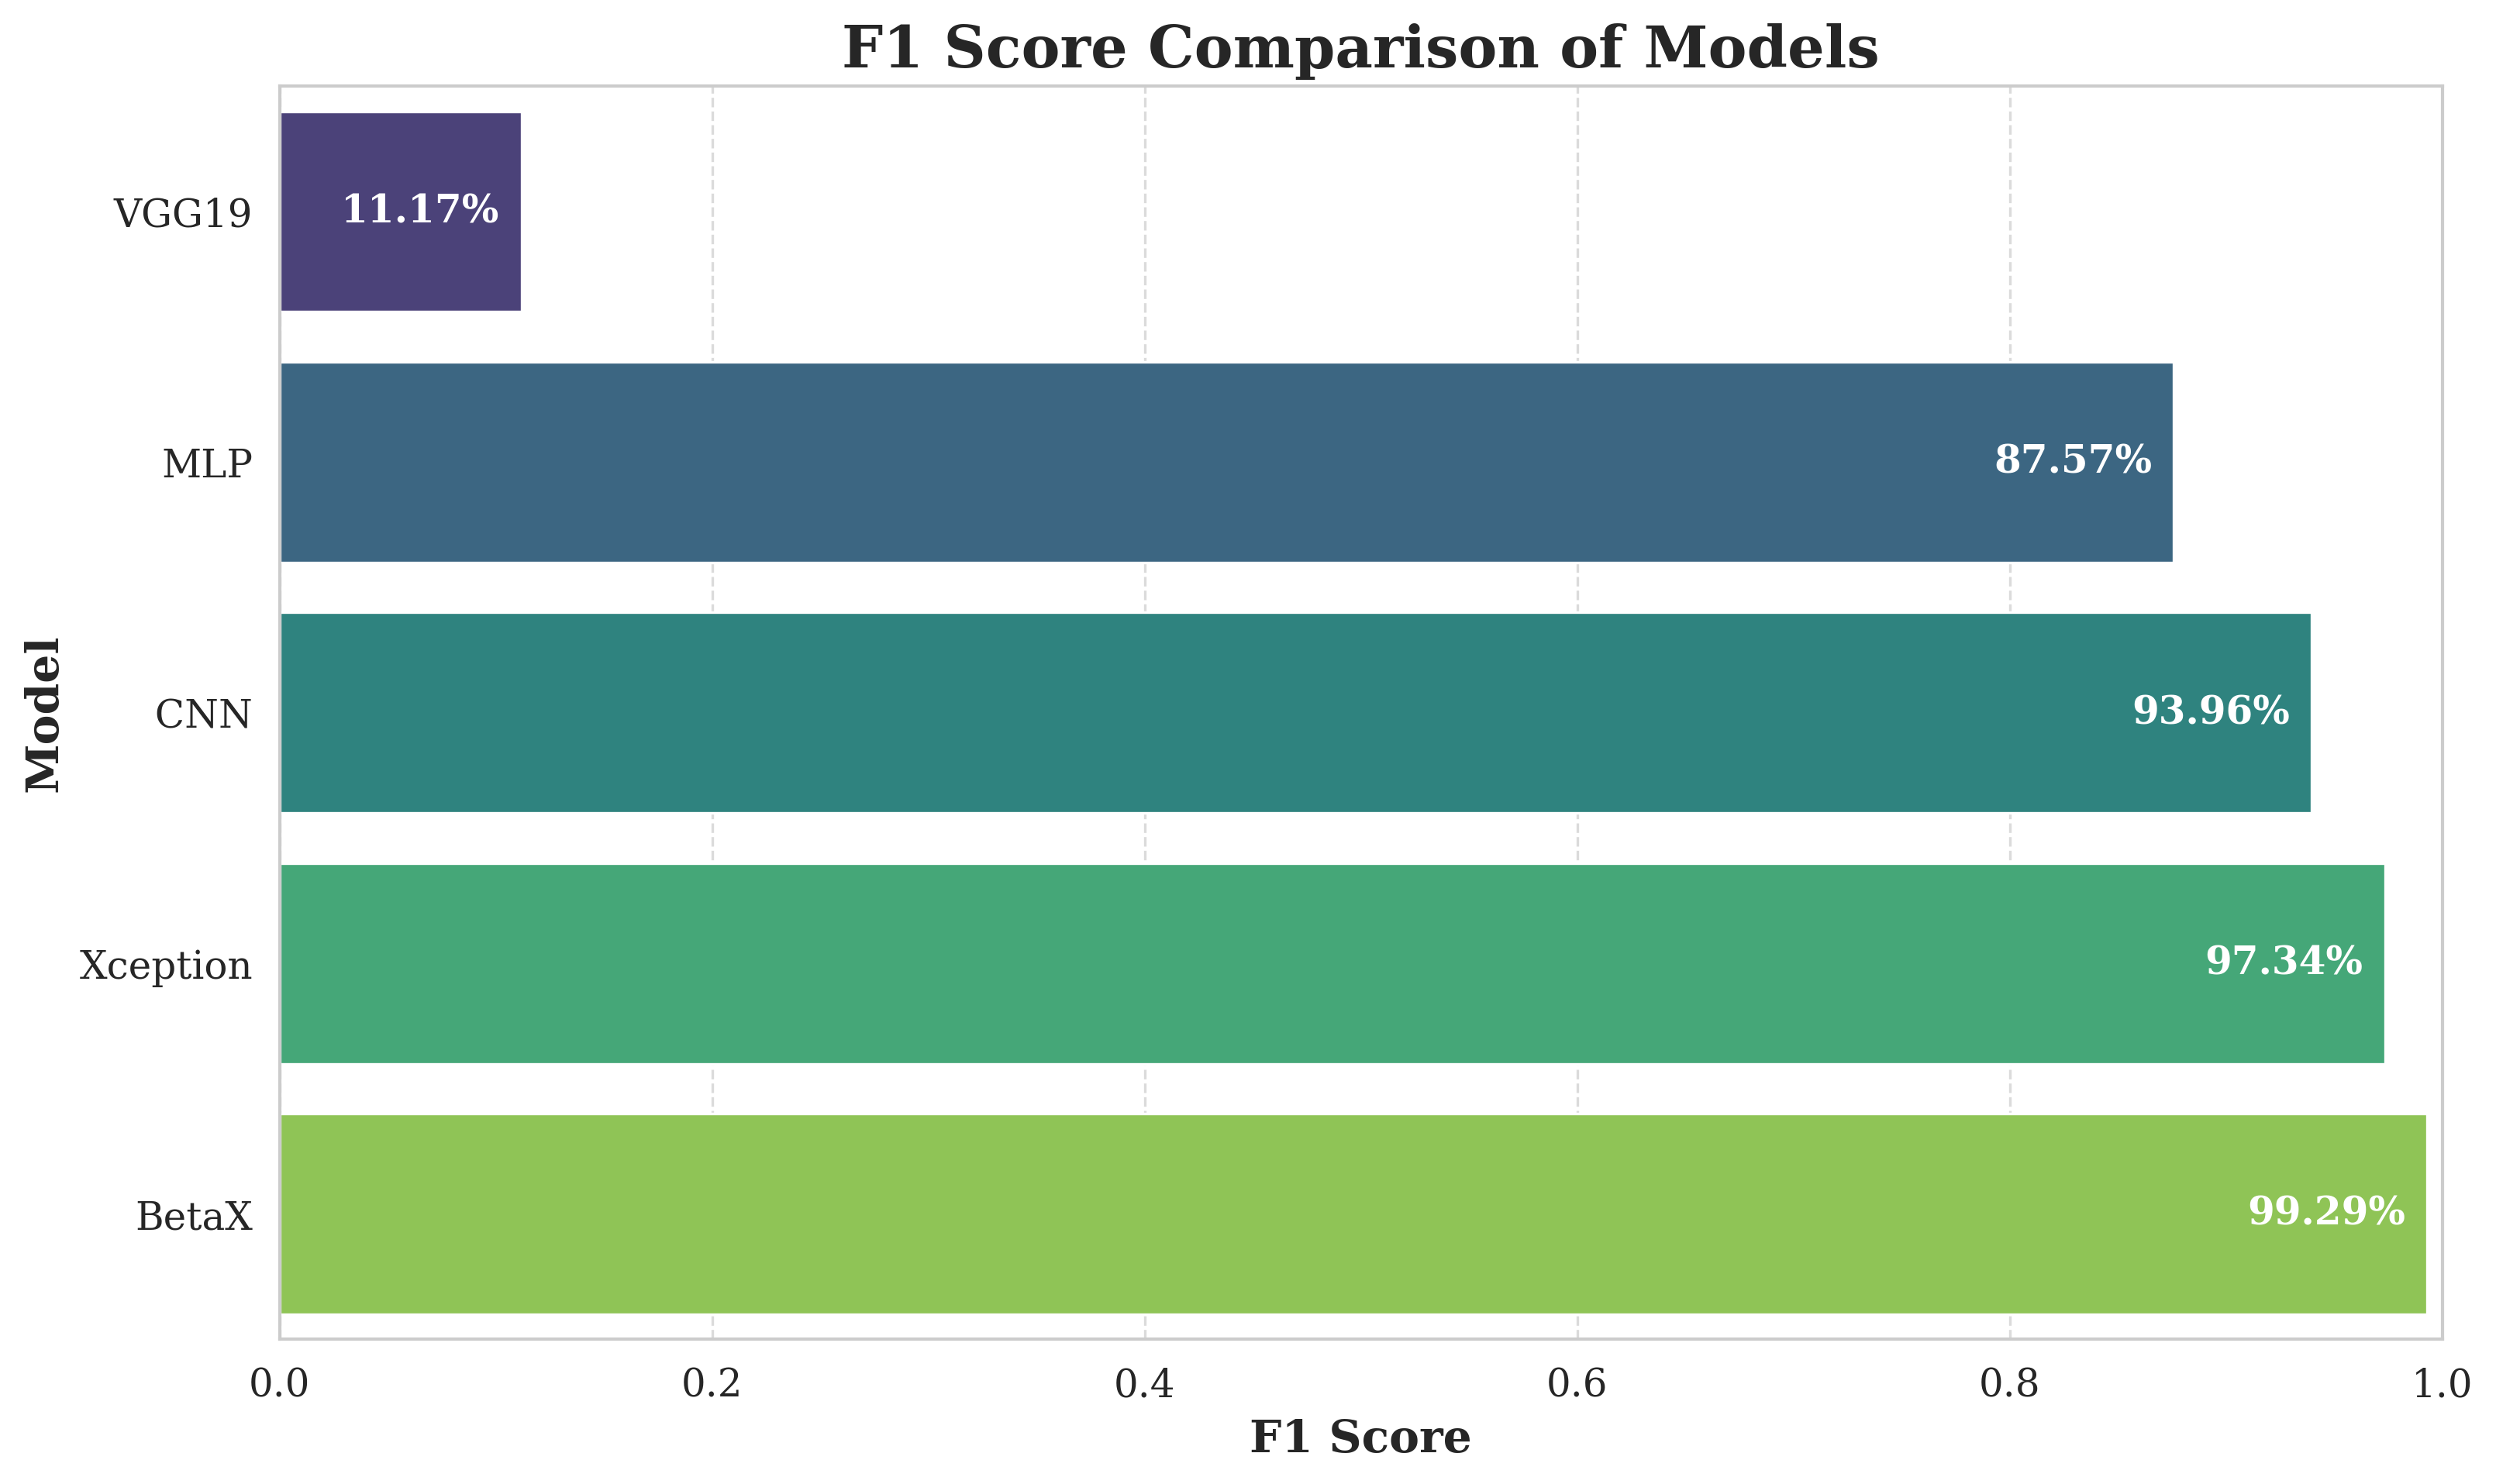

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

f1_scores = {}
for name, res in results.items():
    model = res['model']
    y_pred_probs = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true_classes = np.argmax(y_true, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    f1_scores[name] = f1

f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score']).sort_values(by='F1 Score')

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='F1 Score', y='Model', data=f1_df, palette='viridis')
plt.title('F1 Score Comparison of Models', fontsize=18, weight='bold')
plt.xlabel('F1 Score', fontsize=14, weight='bold')
plt.ylabel('Model', fontsize=14, weight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for p in ax.patches:
    width = p.get_width()
    plt.text(width - 0.01, p.get_y() + p.get_height()/2,
             f'{width:.2%}',
             ha='right', va='center', color='white', weight='bold')

plt.show()